In [1]:
using JLD2
using FourierFlows
using CairoMakie
using Printf
using AbstractFFTs

include("AnalysisUtils.jl")
include("../../utils/IFMAB3.jl")
include("../../swqg/SWQG.jl")
include("../../swqg/TwoLayerQG.jl")
include("../../rsw/RSWUtils.jl")

compute_balanced_wave_weights (generic function with 1 method)

In [2]:
function normal_strain(uh, vh, grid)
    σnh = @. 1im * (grid.kr * vh + grid.l * uh)
    return irfft(σnh, grid.nx)
end

function shear_strain(uh, vh, grid)
    σsh = @. 1im * (grid.kr * uh - grid.l * vh)
    return irfft(σsh, grid.nx)
end

function vorticity(uh, vh, grid)
    ζh = @. 1im * (grid.kr * vh - grid.l * uh)
    return irfft(ζh, grid.nx)
end

function strain(uh, vh, grid)
    σs = normal_strain(uh, vh, grid)
    σn = shear_strain(uh, vh, grid)
    return @. sqrt(σs^2 + σn^2)
end


strain (generic function with 1 method)

In [3]:
function rsw_pv(snapshot, grid, params)
    qh = @. 1im * grid.kr * snapshot[:,:,2] - 1im * grid.l * snapshot[:,:,1] - params.f * snapshot[:,:,3]
    return irfft(qh, grid.nx)
end

function rsw_qg_shear_strain(snapshot, grid, params)
    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(snapshot[:, :, 1], snapshot[:, :, 2], snapshot[:, :, 3], grid, params)
    ζ = vorticity(ugh, vgh, grid)
    σ = strain(ugh, vgh, grid)
    return (; ζ, σ)
end

function shear_strain_from_streamfunction(ψh, grid)
    uh = @. -1im * grid.l  * ψh
    vh = @.  1im * grid.kr * ψh
    ζ = vorticity(uh, vh, grid)
    σ = strain(uh, vh, grid)
    return (; ζ, σ)
end

function swqg_shear_strain(qh, grid, params)
    ψh = similar(qh)
    SWQG.streamfunctionfrompv!(ψh, qh, grid, params)
    return shear_strain_from_streamfunction(ψh, grid)
end

function twoL_shear_strain(qh, grid, params)
    ψh = similar(qh)
    TwoLayerQG.streamfunctionfrompv!(ψh, qh, grid, params)
    ψth = @views (ψh[:,:,1] + ψh[:,:,2])/2
    return shear_strain_from_streamfunction(ψth, grid)
end

twoL_shear_strain (generic function with 1 method)

In [10]:
rsw_grid = TwoDGrid(;nx=512, Lx=2π)
ray_grid = TwoDGrid(;nx=512,  Lx=2π)

#rsw_directory  = "/vast/nad9961/rsw/59916630/1/" # (2048x2048 grid)
#rsw_directory = "/scratch/nad9961/rsw/57478245/1/" # (512x512 grid)
rsw_directory = "/vast/nad9961/rsw/60577145/" # Identical to MRSW run

#mrsw_directory = "/scratch/nad9961/mrsw/60329114"
mrsw_directory = "/vast/nad9961/mrsw/60577143/" # Identical to RSW run

twoL_directory = "/scratch/nad9961/twolayer_rays/60030361"

#swqg_directory = "/scratch/nad9961/swqg/60030992/7"
swqg_directory = "/scratch/nad9961/swqg/60370119/1/"

rsw_params  = read_rsw_params(rsw_directory)
mrsw_params = read_rsw_params(mrsw_directory)
twoL_params = read_2Lqg_params(twoL_directory)
swqg_params = read_swqg_params(swqg_directory, "swqg")

N_rsw_snapshots  = count_key_snapshots(rsw_directory,  "rsw")
N_mrsw_snapshots = count_key_snapshots(mrsw_directory, "rsw")
N_twoL_snapshots = count_key_snapshots(twoL_directory, "2Lqg")
N_swqg_snapshots = count_key_snapshots(swqg_directory, "swqg")

t_rsw,  rsw_sol  = load_key_snapshot(rsw_directory,  "rsw",  N_rsw_snapshots)
t_mrsw, mrsw_sol = load_key_snapshot(mrsw_directory, "rsw",  N_mrsw_snapshots)
t_twoL, twoL_qh  = load_key_snapshot(twoL_directory, "2Lqg", N_twoL_snapshots)
t_swqg, swqg_qh  = load_key_snapshot(swqg_directory, "swqg", 165)

rsw_q  = rsw_pv(rsw_sol,  rsw_grid, rsw_params)
mrsw_q = rsw_pv(mrsw_sol, rsw_grid, mrsw_params)
twoL_q_full = irfft(twoL_qh, ray_grid.nx, (1,2))
twoL_q = @views (twoL_q_full[:,:,1] + twoL_q_full[:,:,2])/2
swqg_q = irfft(swqg_qh, ray_grid.nx)

rsw_ζ,  rsw_σ  = rsw_qg_shear_strain(rsw_sol,  rsw_grid, rsw_params)
mrsw_ζ, mrsw_σ = rsw_qg_shear_strain(mrsw_sol, rsw_grid, mrsw_params)
twoL_ζ, twoL_σ = twoL_shear_strain(twoL_qh, ray_grid, twoL_params)
swqg_ζ, swqg_σ = swqg_shear_strain(swqg_qh, ray_grid, swqg_params)

println(@sprintf("RSW time:  %0.3f", t_rsw))
println(@sprintf("MSW time:  %0.3f", t_mrsw))
println(@sprintf("SWQG time: %0.3f", t_swqg))
println(@sprintf("2L time:   %0.3f", t_twoL))

RSW time:  1184.531
MSW time:  1184.531
SWQG time: 1177.614
2L time:   10137.974


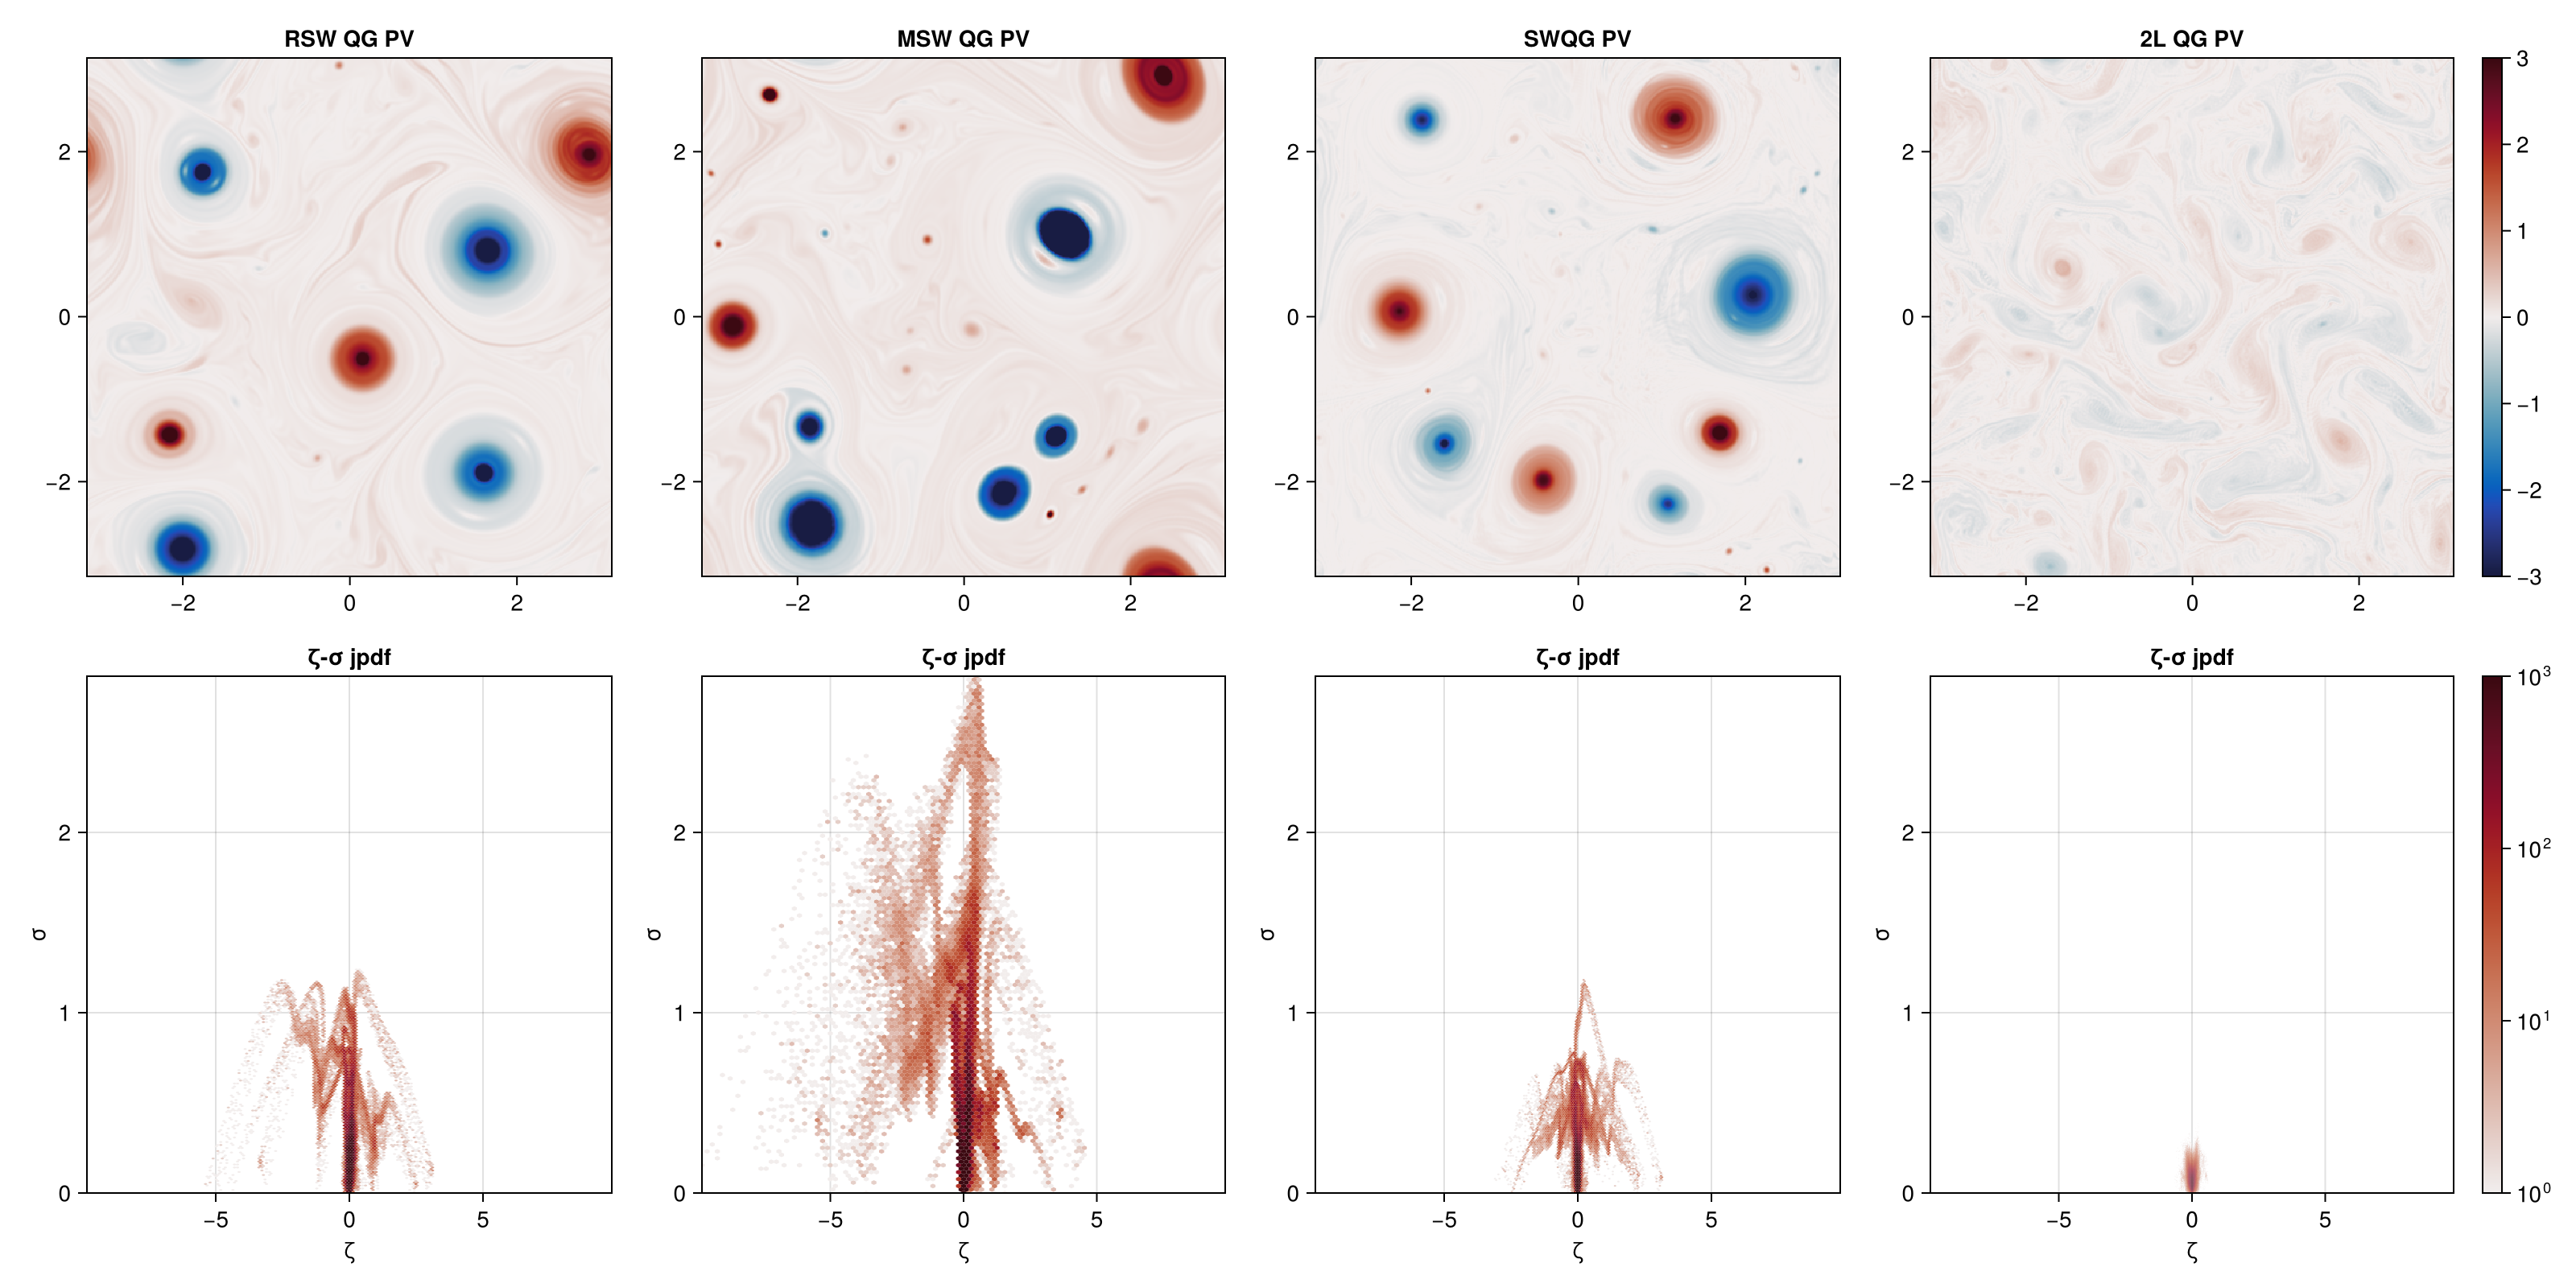

In [11]:
max_ζ = max(maximum(abs.(rsw_ζ)), maximum(abs.(twoL_ζ)), maximum(abs.(swqg_ζ)), maximum(abs.(mrsw_ζ)))
max_σ = max(maximum(rsw_σ), maximum(twoL_σ), maximum(swqg_σ), maximum(mrsw_σ))

hexbin_ax_opts = (; xlabel = "ζ", ylabel="σ", title="ζ-σ jpdf", limits=((-max_ζ, max_ζ), (0, max_σ)))
hexbin_opts = (; bins=150, colorscale=log10, colorrange=(1, 1e3), colormap=:amp)
ζ_opts = (; colorrange=(-3, 3), colormap=:balance)

fig = Figure(size=(1600, 800))
rsw_ζ_ax  = Axis(fig[1,1], title = "RSW QG PV")
mrsw_ζ_ax  = Axis(fig[1,2], title = "MSW QG PV")
swqg_ζ_ax = Axis(fig[1,3], title = "SWQG PV")
twoL_ζ_ax = Axis(fig[1,4], title = "2L QG PV")

rsw_ζσ_ax  = Axis(fig[2,1]; hexbin_ax_opts...)
mrsw_ζσ_ax = Axis(fig[2,2]; hexbin_ax_opts...)
swqg_ζσ_ax = Axis(fig[2,3]; hexbin_ax_opts...)
twoL_ζσ_ax = Axis(fig[2,4]; hexbin_ax_opts...)


heatmap!(rsw_ζ_ax,  rsw_grid.x, rsw_grid.y,  rsw_q; ζ_opts...)
heatmap!(mrsw_ζ_ax, rsw_grid.x, rsw_grid.y, mrsw_q; ζ_opts...)
heatmap!(swqg_ζ_ax, ray_grid.x, ray_grid.y, swqg_q; ζ_opts...)
hm = heatmap!(twoL_ζ_ax, ray_grid.x, ray_grid.y, twoL_q; ζ_opts...)

cbar1 = Colorbar(fig[1,5], hm)

hexbin!(rsw_ζσ_ax,  rsw_ζ[:],  rsw_σ[:];  hexbin_opts...)
hexbin!(mrsw_ζσ_ax, mrsw_ζ[:], mrsw_σ[:]; hexbin_opts...)
hexbin!(swqg_ζσ_ax, swqg_ζ[:], swqg_σ[:]; hexbin_opts...)
hb = hexbin!(twoL_ζσ_ax, twoL_ζ[:], twoL_σ[:]; hexbin_opts...)

cbar2 = Colorbar(fig[2,5], hb)

save("images/joint-strain-vorticity-plots.png", fig)
fig

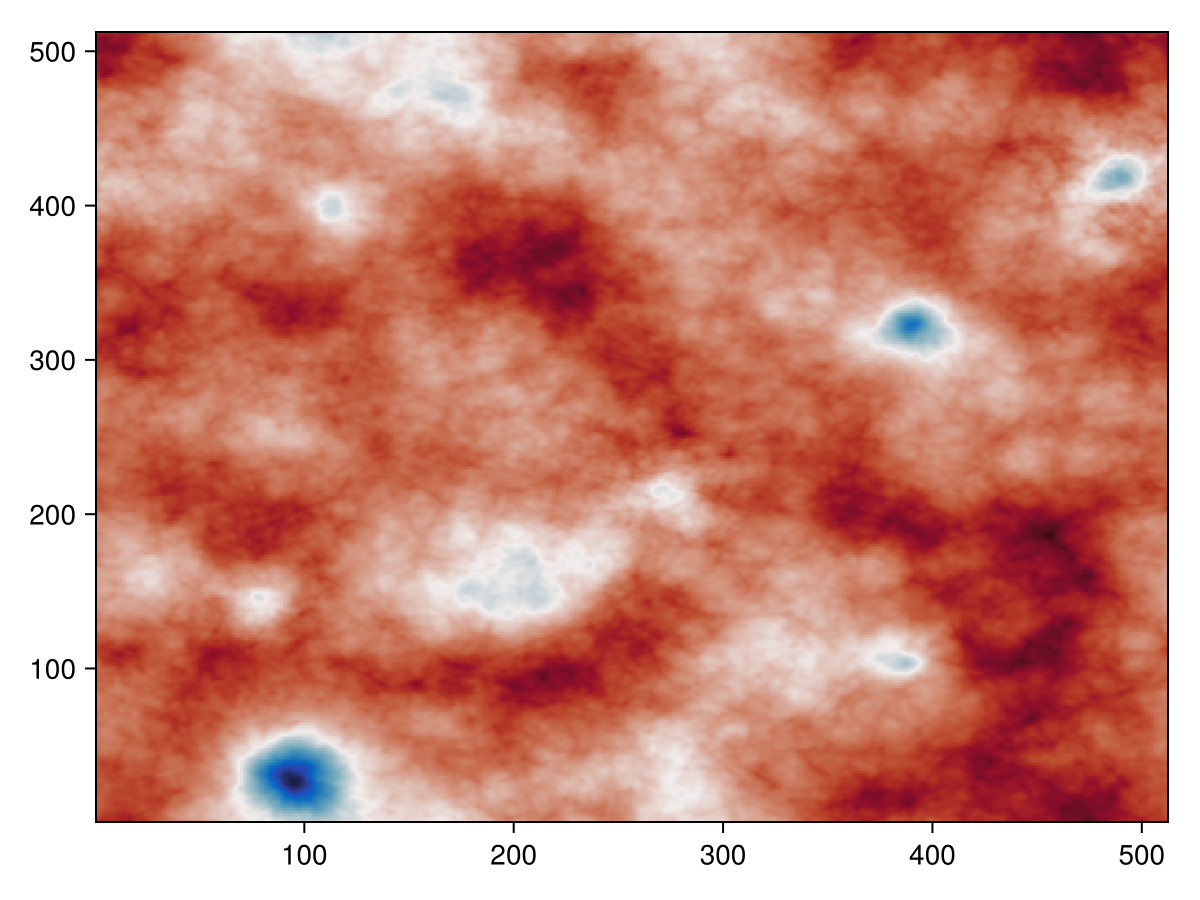

In [17]:
Φ₀, Φ₊, Φ₋ = compute_balanced_wave_bases(rsw_grid, rsw_params)
_, ch₊, ch₋ = compute_balanced_wave_weights(rsw_sol[:,:,1], rsw_sol[:,:,2], rsw_sol[:,:,3], Φ₀, Φ₊, Φ₋)
wave_modeh = ch₊ + ch₋
wave_mode = irfft(wave_modeh, rsw_grid.nx)
heatmap(wave_mode, colormap=:balance)

In [13]:
sqrt.(sum(abs2.(irfft(rsw_sol[:,:,3], rsw_grid.nx))/rsw_grid.nx/rsw_grid.ny))

0.08684469f0

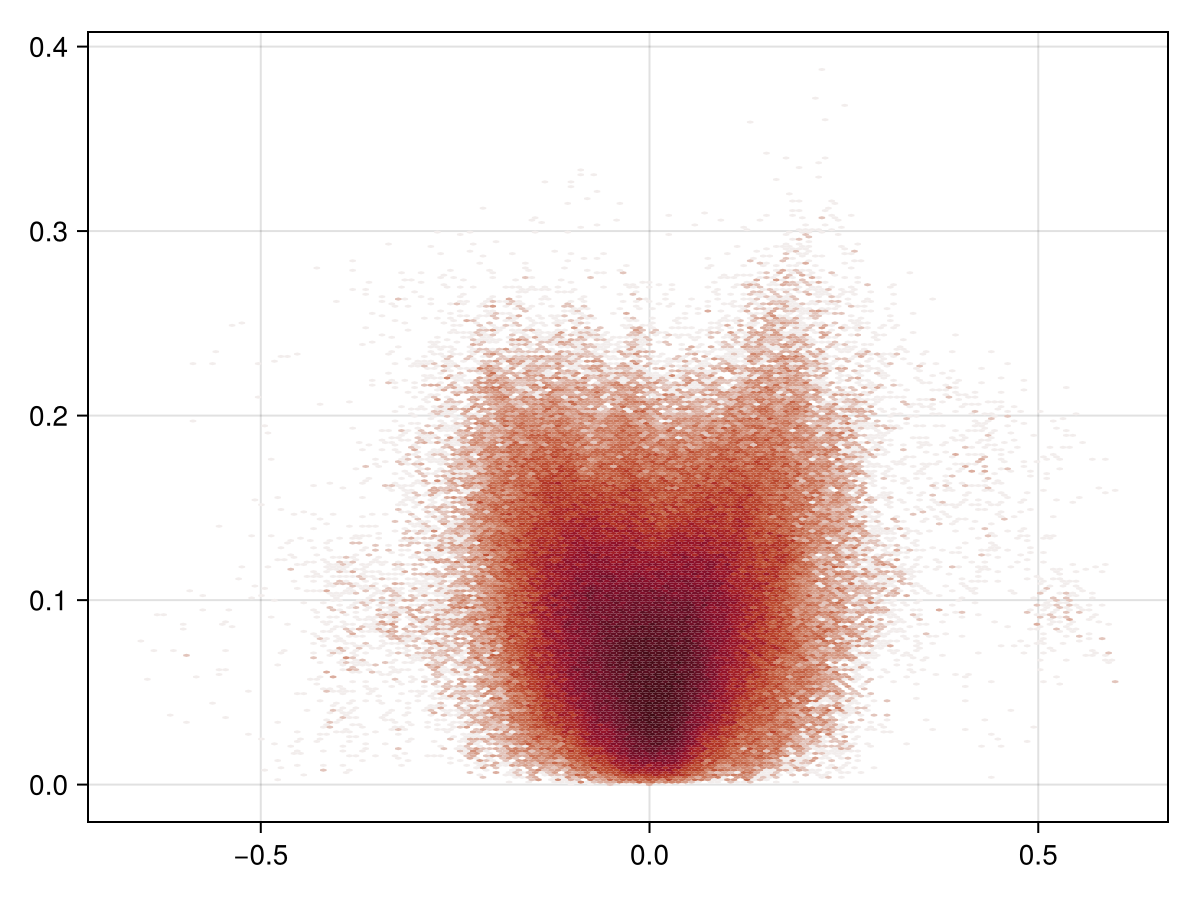

In [14]:
hexbin(twoL_ζ[:], twoL_σ[:], bins=300, colorscale=log10,colormap=:amp)

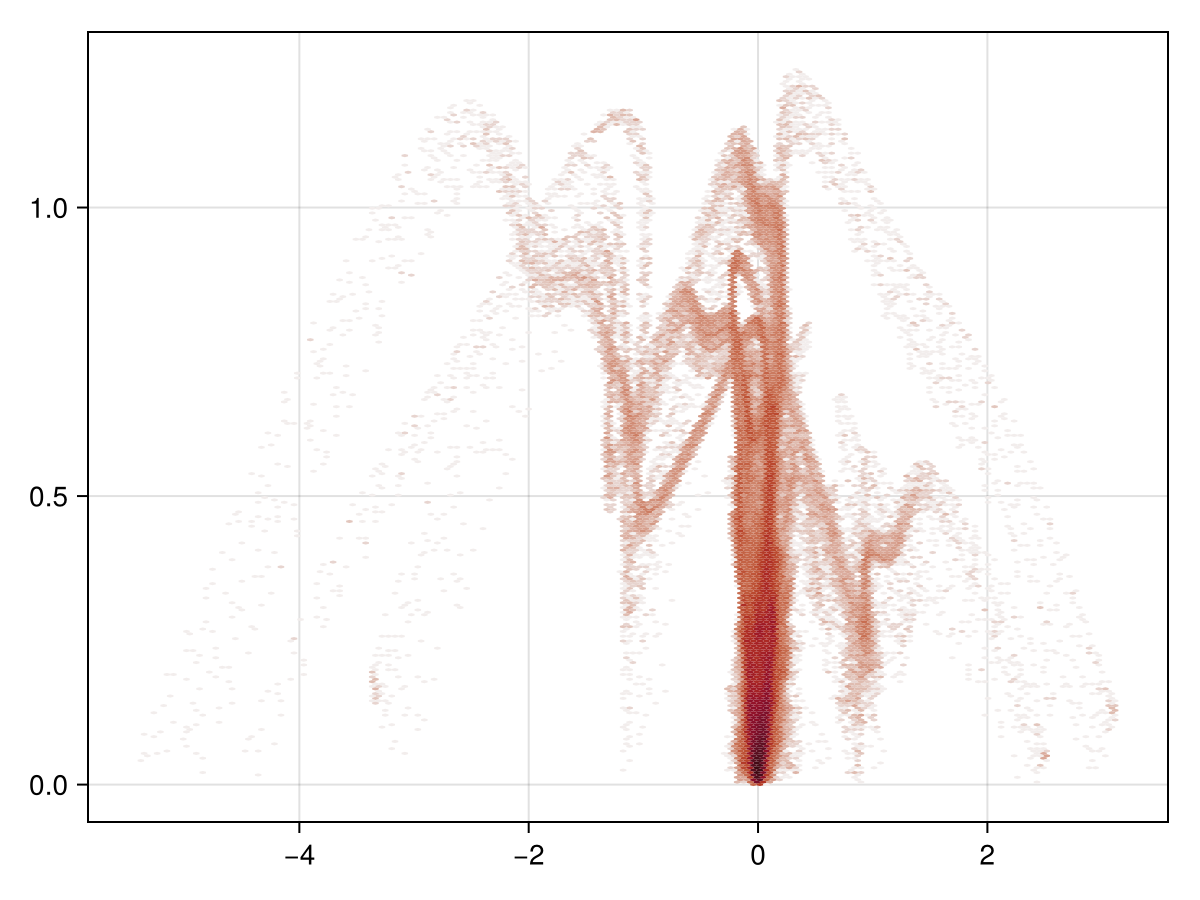

In [15]:
hexbin(rsw_ζ[:], rsw_σ[:], bins=300, colorscale=log10,colormap=:amp)